# Model

In [84]:
from custom_transformers import ModifiedBertForSequenceClassification
from transformers import AutoTokenizer
import torch

In [ ]:
model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained('/home/Models/TookaBERT-Base/', )

In [3]:
tokens = tokenizer(
    text=['سلام', 'خوبی؟', 'حالت چطوره؟'],
    return_tensors='pt',
    padding=True,
    truncation=True
).to(model.device)

In [4]:
labels = torch.randint(0, 2, (3,163), dtype=torch.float32)

In [15]:
outputs = model(**tokens, labels=labels.to(model.device))

In [18]:
outputs.keys()

odict_keys(['loss', 'logits'])

In [19]:
model.config.problem_type

'multi_label_classification'

# DataLoader

In [ ]:
from custom_transformers import ModifiedBertForSequenceClassification
from custom_transformers.utils.data import SQLDataset
from custom_transformers.utils.loss import CombinedLoss, FocalLossWithWeight
from torch.utils.data import DataLoader
from transformers import get_scheduler
from torch.optim import AdamW
import torch
import os
from tqdm import tqdm
from ast import literal_eval
from dotenv import load_dotenv
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
load_dotenv()

model = ModifiedBertForSequenceClassification.from_pretrained(
    '/home/Models/TookaBERT-Base/',
    num_labels=163,
    device_map='auto',
)

connection_params = {
    'dbname': os.getenv('DBNAME'),
    'user': os.getenv('USERNAME'),
    'password': os.getenv('PASS'),
    'host': os.getenv('HOST', 'localhost'),
    'port': os.getenv('PORT', '5432')
}
dataset = SQLDataset(
    pretrained_model_name_or_path='/home/Models/TookaBERT-Base/',
    connection_params=connection_params,
    num_classes=163
)

In [3]:
for name, param in model.named_parameters():
    if name not in ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']:
        param.requires_grad = False

In [7]:
cursor = dataset.connection.cursor()

In [ ]:
query = """
    SELECT labels2
    FROM dbo.activity 
    WHERE labels2 IS NOT NULL AND labels2 NOT LIKE '%[]%'
"""

cursor.execute(query)
labels = [literal_eval(row[0]) for i, row in enumerate(cursor.fetchall())]

# Flatten the list to count occurrences of each label
flat_labels = [label for sublist in labels for label in sublist]

# Count occurrences of each label
label_counts = Counter(flat_labels)

label_counts# Total number of samples
total_samples = sum(label_counts.values())

# Inverse of frequency for each class
class_weights = {label: total_samples / count for label, count in label_counts.items()}

# Normalize weights (optional but can help to stabilize training)
max_weight = max(class_weights.values())
class_weights = {label: weight / max_weight for label, weight in class_weights.items()}

num_classes = 163
class_weights_tensor = torch.zeros(num_classes, dtype=torch.float32)

for label, weight in class_weights.items():
    class_weights_tensor[label] = weight
class_weights_tensor = class_weights_tensor.to(model.device)

# Apply log transformation and scaling
log_scaled_weights = torch.log(class_weights_tensor + 1e-10)  # Avoid log(0)
log_scaled_weights = (log_scaled_weights - log_scaled_weights.min()) / (log_scaled_weights.max() - log_scaled_weights.min())

# Scale class weights from [0, 1] to [0.2, 1]
scaled_class_weights = 0.8 * log_scaled_weights + 0.2

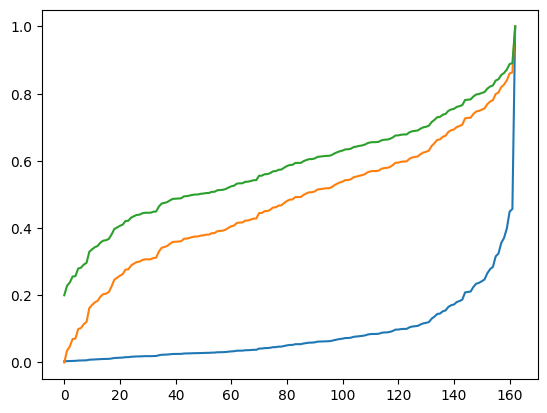

In [50]:
plt.plot(sorted(class_weights_tensor))
plt.plot(sorted(log_scaled_weights))
plt.plot(sorted(scaled_class_weights))

In [ ]:
dataloader = DataLoader(dataset, 512, shuffle=True, collate_fn=dataset.collate_fn, num_workers=1)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CombinedLoss(gamma=2, alpha=0.043, class_weights=class_weights_tensor, focal_weight=1 - 1/163, bce_weight=1/163)
# loss_fn = FocalLossWithWeight(gamma=2, alpha=0.043, class_weights=scaled_class_weights)

num_epochs = 10
num_training_steps = len(dataloader) * num_epochs 
warmup_steps = int(0.1 * num_training_steps)

scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps
)

In [ ]:
# Training loop
learning_rates = []
running_loss = []

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=True)
    
    for batch in progress_bar:
        batch = batch.to(model.device)
        
        input_ids, attention_mask, label = batch.values()
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs['logits']
        loss = loss_fn(logits, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate after each step

        # Track the loss
        running_loss.append(loss.item())
        
        # Track the learning rate
        lr = optimizer.param_groups[0]['lr']
        learning_rates.append(lr)
        
        # Update progress bar with both loss and learning rate
        progress_bar.set_postfix(loss=running_loss[-1], next_lr=lr)
    

Epoch 10: 100%|██████████| 216/216 [05:23<00:00,  1.50s/it, loss=0.00221, lr=0]      


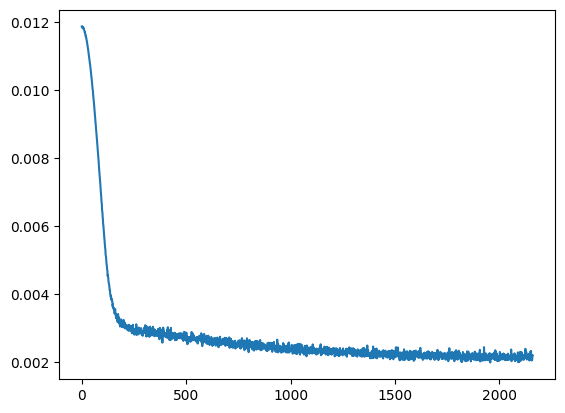

In [24]:
plt.plot(running_loss)

In [58]:
tokens = dataset.tokenizer(
    'ارایه کلیه خدمات مهندسی کشاورزی شامل مشاوره اجرا نظارت بر اجرای انواع طرحهای ابیاری قطره ای بارانی تحت فشار و برقی کردن چاه های کشاورزی جهت بهبود عملیات زراعی در مزارع کشاورزی و باغات و تسطیح و اماده سازی و ابخیزداری و زهکشی کلیه زمینهای کشاورزی باغداری ایجاد فضای سبز گلخانه های فضای ازاد تهیه تولید تکثیر و پرورش گلهای اپارتمانی و انواع نهال تهیه تولید خرید فروش بسته بندی واردات صادرات انواع کودهای شیمیایی انواع بذر و نشا و کمپوست و سموم نباتی و ماشین الات کشاورزی و دامپروری ارایه خدمات مشاوره در زمینه بهبود عملیات زراعی و باغداری شناسایی و ردیابی افات زراعی و از بین بردن این افات بصورت علمی شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه امور بازرگانی شامل واردات صادرات ترخیص حق العمل کاری کلیه کالاهای مجاز از کلیه گمرکات و بنادر کشور و شرکت در مناقصه ها و مزایده های دولتی و شخصی اخذ نمایندگی از شرکتهای داخلی و خارجی انجام کلیه عملیات اجرایی انواع طرحهای مخابراتی تاسیساتی ساختمانی راهسازی و گاز رسانی ابرسانی شهری و روستایی صنعتی شامل حفاری کابل کشی لوله گذاری کانال سازی خاکبرداری و جدول کشی انجام کلیه امور پروژه های ساختمانی مسکونی اسفالت کاری اسکلت سازی و محوطه سازی و تخریب و خاکبرداری خاکریزی و پی کنی دیوار چینی کلیه امور نقشه کشی (Gps – GPRS) کلیه امور اسنادی (خدمات اسنادی قبض انبار منطقه ویژه اصلاحیه مانیفست صورتحساب مجوز خروج کالا (بیجک) تسویه و صورت مجالس شناور صورت وضعیت خروج شناور)',
    truncation=True,
    padding=True,
    return_tensors='pt'
)

In [60]:
with torch.no_grad():
    output = model(**tokens.to('cuda'))

In [70]:
torch.argwhere(torch.sigmoid(output['logits'][0]) > 0.3).cpu().view(-1)

tensor([ 25,  26,  29,  30,  40,  85, 142, 159])

In [51]:
torch.argwhere(torch.sigmoid(outputs['logits'][11]) > 0.3)

tensor([[29],
        [33],
        [85]], device='cuda:0')

In [75]:
dataset.tokenizer.save_pretrained('./saved_models/myBERT-Base/')
model.save_pretrained('./saved_models/myBERT-Base/')